In [17]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy import linalg
from tqdm import tqdm

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
size_plot = 4
Ps = {k: v() for k, v in CalculatedP(size = size_plot).transform_funcs.items()}
map_kwargs = {
    'data_kwargs': {'grid_size': (1, 7), 'noise_std': 1},
    'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False},
    'data_dir': '../data/noise'
}
Ps_1d = get_and_check_Ps(seeds=[1], map_kwargs=map_kwargs, use_P_from_noise = True)
Ps['1d'] = Ps_1d[0]

map_kwargs = {
    'data_kwargs': {'grid_size': (7, 7), 'noise_std': 1},
    'transform_kwargs': {'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip': False},
    'data_dir': '../data/noise'
}
Ps_2d = get_and_check_Ps(seeds=[1], map_kwargs=map_kwargs, use_P_from_noise = True)
Ps['2d'] = Ps_2d[0]

Found run_id xxidyaps
Found run_id vhgrhmcw


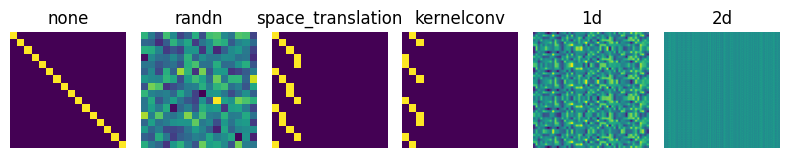

In [19]:
imshows(list(Ps.values()), titles = list(Ps.keys()), axis_off=True, l = 2)

In [20]:
def decompose_matrix(M):
    U, S, Vh = np.linalg.svd(M)
    return U, S, Vh

def reconstruct_matrix(U, S, Vh, k):
    return U[:, :k] @ np.diag(S[:k]) @ Vh[:k, :]

def evaluate(M, R):
    fro_ratio = np.linalg.norm(M - R, 'fro') / np.linalg.norm(M, 'fro')
    if type(R) == np.ndarray:
        R = torch.from_numpy(R)
    mse_loss = torch.nn.functional.mse_loss(M, R).item()
    return fro_ratio, mse_loss

In [22]:
results = {}

for name, P in Ps.items():
    n = P.shape[1]

    if n < 100:
        ks = list(range(0, n, 1))
    else:
        ks = list(range(0, 20, 1)) + list(range(20, 500, 5)) + list(range(500, n, 100))

    U, S, Vh = decompose_matrix(P)

    fros, mses = [], []
    for k in tqdm(ks, leave=False, desc=name):
        R = reconstruct_matrix(U, S, Vh, k)
        fro, mse = evaluate(P, R)
        fros.append(fro)
        mses.append(mse)

    results[name] = {'fros': fros, 'mses': mses, 'ks': ks}

In [23]:
titles = {
    'none' : 'Vanilla',
    'randn' : 'Random',
    'space_translation' : r'Analytical $ST(1)$',
    'kernelconv' : r'1D Convolution',
    '1d' : r'Trained $T(1)$'  + '\ngrid_size = (1,7)',
    '2d' : r'Trained $SO(2)$' + '\ngrid_size = (7,7)',
}

color_normal, color_log = 'tab:blue', 'tab:orange'

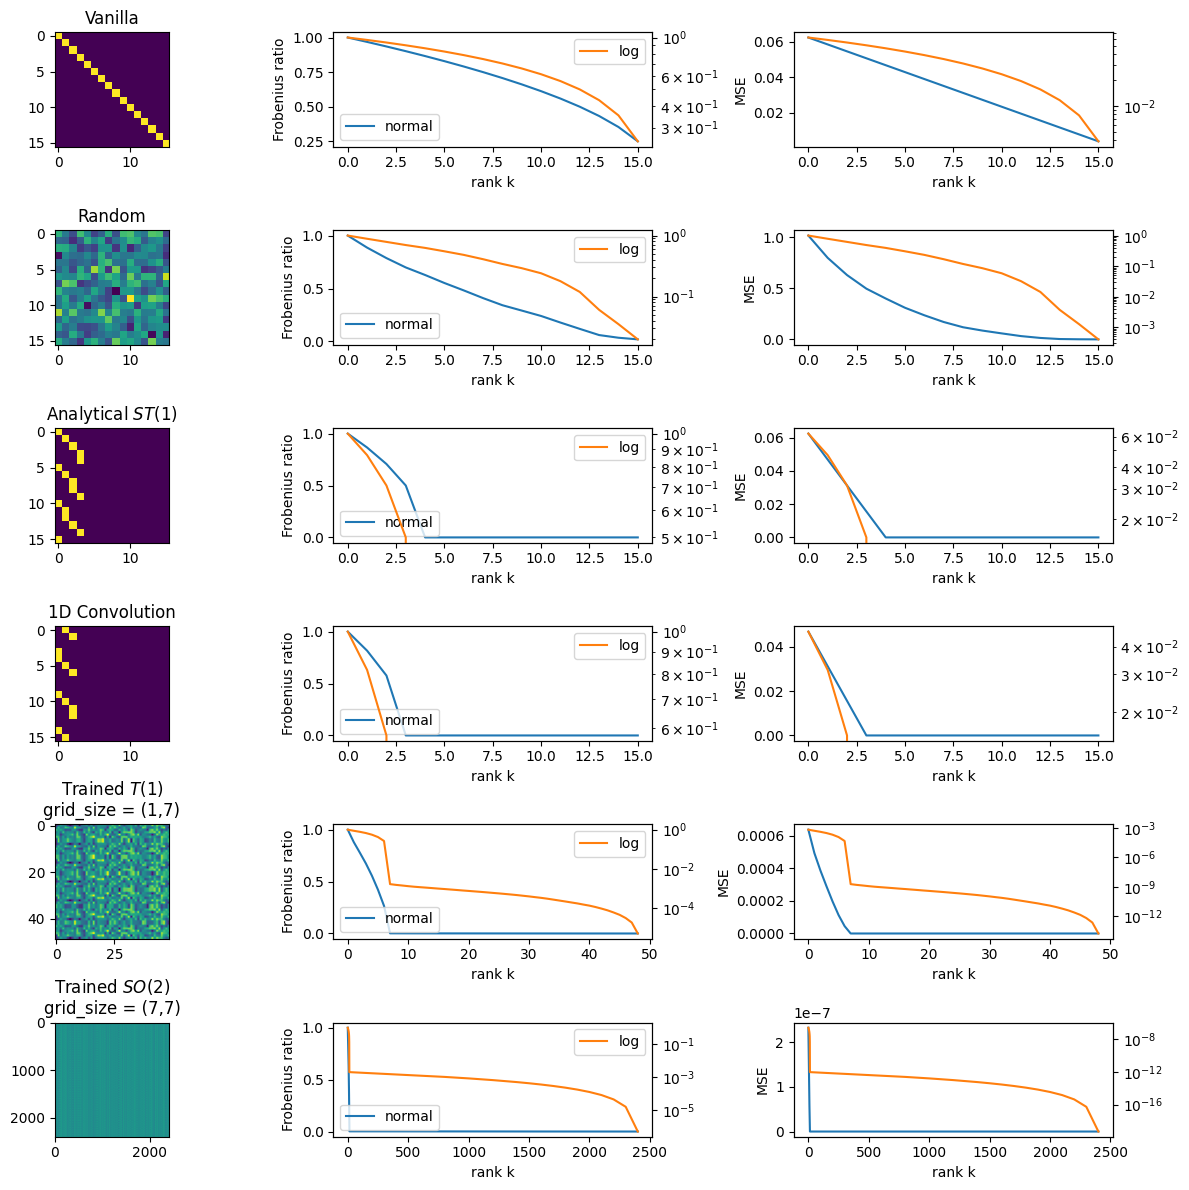

In [24]:
linestyle = '-'

n_P = len(Ps)
fig, axs = plt.subplots(n_P, 3, figsize=(12, 2*n_P), width_ratios=[0.5, 1, 1], tight_layout=True)

for i, (name, res) in enumerate(results.items()):

    ks, fros, mses = res['ks'], res['fros'], res['mses']

    color = color_normal
    ax = axs[i, 1]
    ax.plot(ks, fros, linestyle, color=color, label = 'normal')

    color = color_log
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.plot(ks, fros, linestyle, color=color, label = 'log')

    ax.set_ylabel('Frobenius ratio')
    ax.set_xlabel('rank k')

    ax.legend(loc='lower left')
    ax2.legend(loc='upper right')

    ax = axs[i, 2]
    color = color_normal
    ax.plot(ks, mses, linestyle, color=color)
    ax.set_xlabel('rank k')
    ax.set_ylabel('MSE')

    color = color_log
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.plot(ks, mses, linestyle, color=color)

    ax = axs[i, 0]
    ax.imshow(Ps[name])
    ax.set_title(titles.get(name, name))

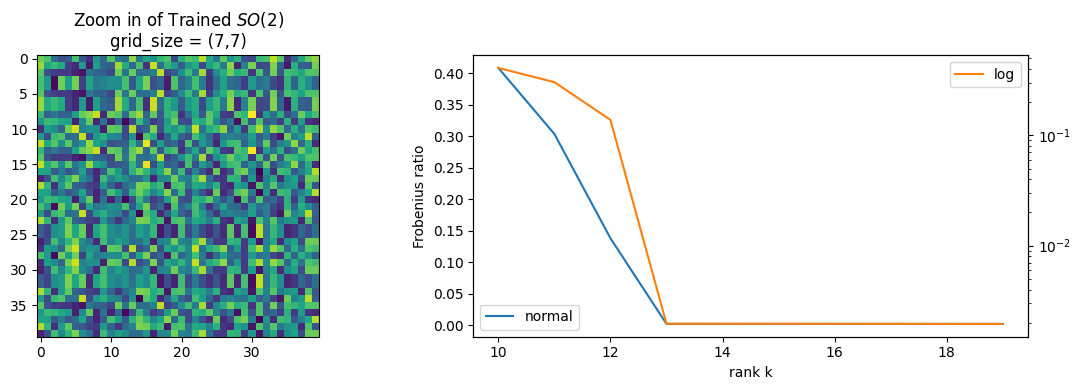

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

s = 40
l1, l2 = 10, 20

dataset = '2d'

ax = axs[0]
ax.imshow(Ps[dataset][:s, :s])
ax.set_title(f"Zoom in of {titles[dataset]}")

ax = axs[1]
ax.plot(results[dataset]['ks'][l1:l2], results[dataset]['fros'][l1:l2], linestyle, label = 'normal', color=color_normal)
ax.set_ylabel('Frobenius ratio')
ax.set_xlabel('rank k')
ax.legend(loc='lower left')
# ax.set_xscale('log')

ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.plot(results[dataset]['ks'][l1:l2], results[dataset]['fros'][l1:l2], linestyle, label = 'log', color=color_log)
ax2.legend(loc='upper right')


plt.show()

In [89]:
ks, fros = results['2d']['ks'], results['2d']['fros']

for k, fro in zip(ks, fros):
    if fro < 0.1:
        print(k, fro)

13 0.00196074
14 0.0019590978
15 0.0019574554
16 0.0019558219
17 0.0019541867
18 0.0019525565
19 0.0019509454
20 0.0019493332
25 0.0019413368
30 0.0019334301
35 0.0019255987
40 0.0019178428
45 0.0019101484
50 0.0019025252
55 0.0018949332
60 0.0018873923
65 0.0018798995
70 0.0018724351
75 0.001865022
80 0.0018576337
85 0.0018502952
90 0.0018430003
95 0.0018357465
100 0.0018285238
105 0.0018213287
110 0.0018141724
115 0.0018070401
120 0.0017999389
125 0.0017928756
130 0.001785844
135 0.0017788387
140 0.0017718722
145 0.0017649251
150 0.0017580014
155 0.0017511033
160 0.0017442271
165 0.0017373809
170 0.0017305521
175 0.0017237407
180 0.0017169596
185 0.0017101957
190 0.0017034614
195 0.0016967455
200 0.0016900543
205 0.0016833907
210 0.0016767501
215 0.0016701389
220 0.0016635456
225 0.0016569692
230 0.0016504058
235 0.0016438584
240 0.001637335
245 0.001630829
250 0.0016243494
255 0.0016178784
260 0.0016114332
265 0.0016050005
270 0.0015985849
275 0.0015921926
280 0.0015858246
285 0.001